In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from matplotlib import pyplot as plt

In [3]:
# read data
data_path = "./data/data.csv"

raw_data = pd.read_csv(data_path, sep="\t")
df = pd.DataFrame(preprocessing.normalize(raw_data), columns=raw_data.columns)

In [4]:
# 数据取样
train_data = df.sample(frac=0.8, random_state=1)
test_data = df[~df.index.isin(train_data.index)]

In [5]:
# 为给定数据集选取K个随机质心
def pickRandCent(dataSet: pd.DataFrame, k: int) -> dict:
    (n, m) = dataSet.shape
    cent = {}
    i = 0
    while i < k:
        index = int(np.random.uniform(0, n))
        if index not in cent:
            cent[index] = dataSet.iloc[index]
            i = i + 1
    return cent

In [6]:
# 欧氏距离计算
def distEclud(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [7]:
def cluster(dataSet: pd.DataFrame, cent: dict) -> tuple((dict, float)):
    (n, m) = dataSet.shape
    collection = {}
    sse = 0
    for i in range(n):
        minDist = float("inf")
        cate = None
        for dot in cent:
            dist = distEclud(dataSet.iloc[i], cent[dot])
            if dist < minDist:
                minDist = dist
                cate = dot
        if cate == None:
            continue
        if cate not in collection:
            collection[cate] = [dataSet.iloc[i]]
        else:
            collection[cate].append(dataSet.iloc[i])
        dist = distEclud(dataSet.iloc[i], cent[cate])
        sse = sse + dist ** 2
    return collection, sse

In [8]:
def kmeans(
    dataSet: pd.DataFrame,
    k: int = 10,
    cent: dict = None,
    times: int = 10,
    conv: float = 1e-3,
):
    sse = float("inf")
    for i in range(1, times + 1):
        # 选出新的质心
        if i == 1:
            cent = pickRandCent(dataSet, k)
        else:
            for key in collection:
                cv = np.mean(collection[key], axis=0)
                cent[key] = cv
        collection, nsse = cluster(dataSet, cent)
        # print('Iterate time:%d, SSE:%f' % (i, nsse))
        # showCluser(collection, "Iterate Time: %d" % i, i)
        if (i != 1 and sse == nsse) or (
            not np.isclose(nsse, 0)
            and np.isclose(np.abs(nsse - sse) / nsse, conv)
        ):
            break
        sse = nsse
    return sse, i, cent, collection

In [9]:
def showCluser(
    collection: dict, title: str, time: int, showScatter: bool = False
):
    index = 1
    color = np.random.random(size=(10, 3))
    # if showScatter:
    #     plt.subplot(5,  2, time)
    for key in collection:
        y = collection[key]
        x = np.zeros((len(y),))
        for i in range(len(y)):
            x[i] = np.random.uniform(index - 0.5, index + 0.5)
            if showScatter:
                plt.scatter(
                    x, y, c=np.repeat([color[index - 1]], len((y)), axis=0)
                )
        index = index + 1
    if showScatter:
        plt.title(title)

In [12]:
def KandSSE(
    dataSet: pd.DataFrame, ite: int = 20, conv: float = 1e-3, label: str = ""
):
    sses = np.zeros((ite,))
    ks = np.zeros((ite,))
    for i in range(1, ite + 1):
        sse, iterateTimes, cent, collection = kmeans(dataSet, k=i, times=100)
        sses[i - 1] = sse
        ks[i - 1] = i
        # print("Result:\nSSE: %f, Iterate times: %d" % (sse, i))
        # print(cent)
    plt.plot(ks, sses, label=label)
    plt.legend(loc=0, ncol=2)
    return sses, ks

No handles with labels found to put in legend.


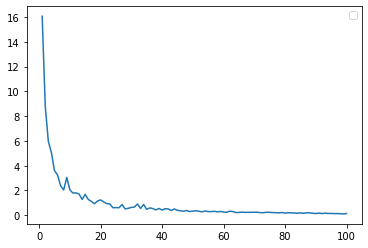

In [13]:
# K值选取收敛测试
sses, ks = KandSSE(train_data, ite=100)

In [14]:
# 保存K收敛曲线
pd.DataFrame({"K": ks.astype(int), "SSE": sses}).to_csv(
    "K_Conv.csv", index=False, sep="\t"
)

In [15]:
# 主程序，数据聚类
sse, times, cent, collection = kmeans(train_data, k=20, times=100)

In [16]:
with open("clustered.dat", "w") as f:
    for cate in collection:
        f.write(f"{cate}\n")
        for item in collection[cate]:
            f.write(f"{item.name}\t")
        f.write("\n\n")

In [21]:
def plotClustered(collection: dict, abnormal: dict = None, xlim: tuple = None):
    index = 1
    color = np.random.random(size=(len(collection), 3))
    if xlim is not None:
        plt.xlim(xlim)
    if abnormal is None:
        for key in collection:
            y = collection[key]
            x = np.zeros((len(y),))
            for i in range(len(y)):
                # x[i] = np.random.uniform(index - 0.5, index + 0.5)
                name = y[i].name
                x[i] = np.sqrt(np.sum(raw_data.iloc[name] ** 2))
            plt.scatter(
                x,
                np.mean(y, axis=1),
                c=np.repeat([color[index - 1]], len((y)), axis=0),
            )
            index = index + 1
    else:
        for key in collection:
            y = []
            x = []
            for item in collection[key]:
                name = item.name
                if len([_ for _ in abnormal[key] if name in _]) > 0:
                    continue
                x.append(np.sqrt(np.sum(raw_data.iloc[name] ** 2)))
                y.append(item)
            plt.scatter(
                x,
                np.mean(y, axis=1),
                c=np.repeat([color[index - 1]], len((y)), axis=0),
            )
            index = index + 1

In [22]:
def pickOutAbnormal(thr: float = 0.1) -> dict:
    abnormal = {}
    for key in collection:
        c = cent[key]
        clen = len(collection[key])
        dists = {}
        abns = []
        avg = 0
        for (idx, item) in enumerate(collection[key]):
            dists[item.name] = distEclud(item, c)
            avg += dists[item.name]
        avg /= clen
        dists = sorted(dists.items(), key=lambda k: k[1], reverse=True)
        for i in range(int(np.ceil(len(dists) * thr))):
            if dists[i][1] > avg:
                abns.append(dists[i])
        abnormal[key] = abns
    return abnormal

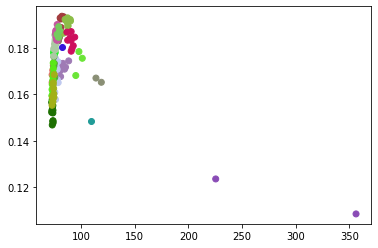

In [23]:
# 绘制聚类数据图
plotClustered(collection, pickOutAbnormal())

In [24]:
def checkAbnormal(cent, collection, data, thr=0.1):
    new_col, sse = cluster(data, cent)
    abnormal = {}
    for key in new_col:
        c = cent[key]
        clen = len(collection[key])
        dists = {}
        abns = []
        avg = 0
        for item in collection[key]:
            dists[item.name] = distEclud(item, c)
            avg += dists[item.name]
        avg /= clen
        dists = sorted(dists.items(), key=lambda k: k[1], reverse=True)
        for item in new_col[key]:
            nd = distEclud(item, c)
            if nd > avg:
                if thr > 0 and thr <= 1:
                    if (
                        nd
                        > np.mean(
                            dists[: int(np.ceil(len(dists) * thr))], axis=0
                        )[1]
                    ):
                        abns.append((item.name, nd))
                else:
                    abns.append((item.name, nd))
        abnormal[key] = abns
    return new_col, abnormal, sse

In [25]:
# 使用训练的结果检测测试数据中的异常数据
new_col, abnormal, sse = checkAbnormal(cent, collection, test_data, 0.1)

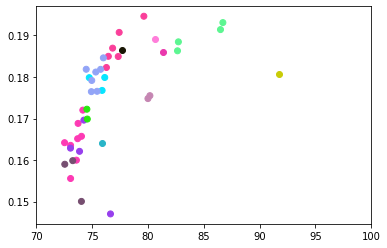

In [26]:
plotClustered(new_col, xlim=(70, 100))

In [31]:
def plotAbnormal(collection: dict, abnormal: dict, xlim: tuple = None):
    index = 1
    color = np.random.random(size=(len(abnormal), 3))
    if xlim is not None:
        plt.xlim(xlim)
    for key in abnormal:
        y = []
        x = []
        for item in abnormal[key]:
            name = item[0]
            x.append(np.sqrt(np.sum(raw_data.iloc[name] ** 2)))
            y.append([_ for _ in collection[key] if name == _.name].pop())
        if len(y) > 0:
            plt.scatter(
                x,
                np.mean(y, axis=1),
                c=np.repeat([color[index - 1]], len((y)), axis=0),
            )
        index = index + 1

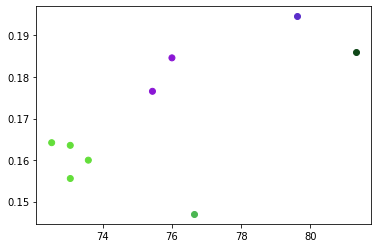

In [32]:
# 绘制检测出的异常数据点
plotAbnormal(new_col, abnormal)